In [0]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from tqdm import tqdm as tqdm

%matplotlib inline

import torch
import torchvision

import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import random

In [3]:
from google.colab import drive

drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
transform = transforms.Compose(
    [transforms.CenterCrop((28,28)),transforms.ToTensor(),transforms.Normalize([0.5], [0.5])])


In [0]:
mnist_trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
mnist_testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

In [240]:
index1 = [np.where(mnist_trainset.targets==0)[0] , np.where(mnist_trainset.targets==1)[0] ]
index1 = np.concatenate(index1,axis=0)
len(index1) #12665

12665

In [0]:
true_training_data =12665
indices = np.random.choice(index1, true_training_data)

In [242]:
x = mnist_trainset.data
y = np.array(mnist_trainset.targets)
mnist_trainset.data = x[indices]
mnist_trainset.targets = y[indices]
len(y[indices])

12665

In [0]:
# index = np.where(np.logical_and(mnist_trainset.targets!=0,mnist_trainset.targets!=1))[0]  #47335

In [0]:
# values = np.random.choice([0,1],size= 47335) 
# print(sum(values ==0),sum(values==1))


In [0]:
# mnist_trainset.data = torch.cat((mnist_trainset.data[indices],mnist_trainset.data[index]))
# mnist_trainset.targets = torch.cat((mnist_trainset.targets[indices],torch.Tensor(values).type(torch.LongTensor)))

AxesImage(54,36;334.8x217.44) 1


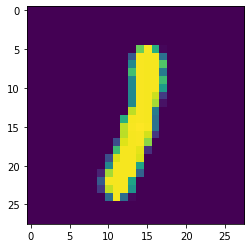

In [245]:
# mnist_trainset.targets[index] = torch.Tensor(values).type(torch.LongTensor)
j = 75   # Without Shuffle upto True Training numbers correct , after that corrupted
print(plt.imshow(mnist_trainset.data[j]),mnist_trainset.targets[j])

In [0]:
trainloader = torch.utils.data.DataLoader(mnist_trainset, batch_size=256,shuffle=True, num_workers=2)

In [0]:
testloader = torch.utils.data.DataLoader(mnist_testset, batch_size=256,shuffle=False, num_workers=2)

In [0]:
classes = ('zero', 'one')

In [0]:
dataiter = iter(trainloader)
images, labels = dataiter.next()

In [250]:
images[:4].shape

torch.Size([4, 1, 28, 28])

In [0]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

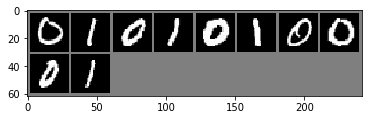

GroundTruth:   zero   one  zero   one  zero   one  zero  zero  zero   one


In [252]:
imshow(torchvision.utils.make_grid(images[:10]))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(10)))

In [0]:
class Conv_module(nn.Module):
    def __init__(self,inp_ch,f,s,k,pad):
        super(Conv_module,self).__init__()
        self.inp_ch = inp_ch
        self.f = f
        self.s = s 
        self.k = k 
        self.pad = pad
        
        
        self.conv = nn.Conv2d(self.inp_ch,self.f,k,stride=s,padding=self.pad)
        self.bn = nn.BatchNorm2d(self.f)
        self.act = nn.ReLU()
    def forward(self,x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.act(x)
        return x

In [0]:
class inception_module(nn.Module):
    def __init__(self,inp_ch,f0,f1):
        super(inception_module, self).__init__()
        self.inp_ch = inp_ch
        self.f0 = f0
        self.f1 = f1
        
        
        
        self.conv1 = Conv_module(self.inp_ch,self.f0,1,1,pad=0)
        self.conv3 = Conv_module(self.inp_ch,self.f1,1,3,pad=1)
        #self.conv1 = nn.Conv2d(3,self.f0,1)
        #self.conv3 = nn.Conv2d(3,self.f1,3,padding=1)
    def forward(self,x):
        x1 = self.conv1.forward(x)
        x3 = self.conv3.forward(x)
        #print(x1.shape,x3.shape)
        
        x = torch.cat((x1,x3),dim=1)
        
    
        return x

In [0]:
class downsample_module(nn.Module):
    def __init__(self,inp_ch,f):
        super(downsample_module,self).__init__()
        self.inp_ch = inp_ch
        self.f = f
        self.conv = Conv_module(self.inp_ch,self.f,2,3,pad=0)
        self.pool = nn.MaxPool2d(3,stride=2,padding=0)
    def forward(self,x):
        x1 = self.conv(x)
        #print(x1.shape)
        x2 = self.pool(x)
        #print(x2.shape)
        x = torch.cat((x1,x2),dim=1)
        
        return x

In [0]:
class inception_net(nn.Module):
    def __init__(self):
        super(inception_net,self).__init__()
        self.conv1 = Conv_module(1,96,1,3,0)
        
        self.incept1 = inception_module(96,32,32)
        self.incept2 = inception_module(64,32,48)
        
        self.downsample1 = downsample_module(80,80)
        
        self.incept3 = inception_module(160,112,48)
   
        self.downsample2 = downsample_module(160,48)
              
        self.pool = nn.AvgPool2d(5)
        
        
        
        self.linear = nn.Linear(208,10)
    def forward(self,x):
        x = self.conv1.forward(x)
        #act1 = x
        
        x = self.incept1.forward(x)
        #act2 = x
        
        x = self.incept2.forward(x)
        #act3 = x
        
        x = self.downsample1.forward(x)
        
        x = self.incept3.forward(x)
        
        x = self.downsample2.forward(x)
        
        #print(x.shape)
        x = self.pool(x)
        #print(x.shape)
        x = x.view(-1,1*1*208)
        #print(x.shape)
        x = self.linear(x) 
        return x

In [0]:
inc = inception_net()
inc = inc.to("cuda")

In [0]:
# inc(images)

In [0]:
criterion_inception = nn.CrossEntropyLoss()
optimizer_inception = optim.SGD(inc.parameters(), lr=0.01, momentum=0.9)

In [260]:
acti = []
loss_curi = []
for epoch in range(80): # loop over the dataset multiple times
    ep_lossi = []

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data
        inputs, labels = inputs.to("cuda"),labels.to("cuda")

        # zero the parameter gradients
        optimizer_inception.zero_grad()

        # forward + backward + optimize
        outputs = inc(inputs)
        loss = criterion_inception(outputs, labels)
        loss.backward()
        optimizer_inception.step()

        # print statistics
        running_loss += loss.item()
        if i % 50 == 49:    # print every 50 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 50))
            ep_lossi.append(running_loss/50) # loss per minibatch
            running_loss = 0.0
            
    loss_curi.append(np.mean(ep_lossi))   #loss per epoch   
            

print('Finished Training')

[1,    50] loss: 0.156
[2,    50] loss: 0.015
[3,    50] loss: 0.009
[4,    50] loss: 0.006
[5,    50] loss: 0.005
[6,    50] loss: 0.004
[7,    50] loss: 0.003
[8,    50] loss: 0.002
[9,    50] loss: 0.002
[10,    50] loss: 0.002
[11,    50] loss: 0.002
[12,    50] loss: 0.002
[13,    50] loss: 0.001
[14,    50] loss: 0.001
[15,    50] loss: 0.001
[16,    50] loss: 0.001
[17,    50] loss: 0.001
[18,    50] loss: 0.001
[19,    50] loss: 0.000
[20,    50] loss: 0.000
[21,    50] loss: 0.000
[22,    50] loss: 0.000
[23,    50] loss: 0.000
[24,    50] loss: 0.000
[25,    50] loss: 0.000
[26,    50] loss: 0.000
[27,    50] loss: 0.000
[28,    50] loss: 0.000
[29,    50] loss: 0.000
[30,    50] loss: 0.000
[31,    50] loss: 0.000
[32,    50] loss: 0.000
[33,    50] loss: 0.000
[34,    50] loss: 0.000
[35,    50] loss: 0.000
[36,    50] loss: 0.000
[37,    50] loss: 0.000
[38,    50] loss: 0.000
[39,    50] loss: 0.000
[40,    50] loss: 0.000
[41,    50] loss: 0.000
[42,    50] loss: 0.000
[

In [261]:
correct = 0
total = 0
with torch.no_grad():
    for data in trainloader:
        images, labels = data
        images, labels = images.to("cuda"), labels.to("cuda")
        outputs = inc(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 60000 train images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 60000 train images: 100 %


In [262]:
total,correct

(12665, 12665)

In [263]:
correct = 0
total = 0
out = []
pred = []
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to("cuda"),labels.to("cuda")
        out.append(labels.cpu().numpy())
        outputs= inc(images)
        _, predicted = torch.max(outputs.data, 1)
        pred.append(predicted.cpu().numpy())
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 21 %


In [0]:
out = np.concatenate(out,axis=0)

In [0]:
pred = np.concatenate(pred,axis=0)

In [266]:
index = np.logical_or(out ==1,out==0)
print(index.shape)

(10000,)


In [267]:
acc = sum(out[index] == pred[index])/sum(index)
print('Accuracy of the network on the 0-1 test images: %d %%' % (
    100*acc))

Accuracy of the network on the 0-1 test images: 99 %


In [268]:
sum(index)

2115

In [0]:
torch.save(inc.state_dict(),"/content/drive/My Drive/Research/MNIST_random/MNIST_random_simple/weights_zero_corruption/model_simple_"+str(true_training_data)+".pkl")

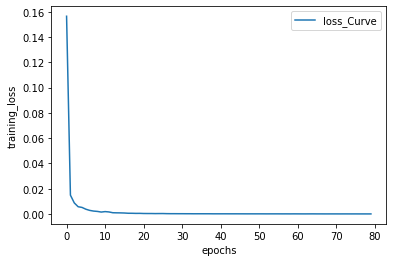

In [270]:
fig = plt.figure()
plt.plot(loss_curi,label="loss_Curve")
plt.xlabel("epochs")
plt.ylabel("training_loss")
plt.legend()
fig.savefig("loss_curve.pdf") 

Simple Model 3 Inception Module

|true training data  | Corr Training Data | Test Accuracy | Test Accuracy 0-1 | 
| ------------------ | ------------------ | ------------- | ----------------- |
| 100   | 0  | 20  |  98 |
| 500   | 0  | 21  |  99 | 
| 1000  | 0  | 21  |  99 | 
| 2000  | 0  | 21  |  99 | 
| 4000  | 0  | 21  |  99 | 
| 6000  | 0  | 21  |  99 | 
| 8000  | 0  | 21  |  99 | 
| 12665 | 0  | 21  |  99 | 


|   Total Training Data       |   Training Accuracy      |
|---------------------------- | ------------------------ |
| 100         | 100 |
| 500         | 100 |
| 1000         | 100 |
| 2000         | 100 | 
| 4000         | 100 |
| 6000         | 100 |
| 8000         | 100 |
| 12665         | 100 |